In [1]:
import colorizerutils as utils
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

tf.__version__

'2.8.0'

In [2]:
# Limit tensorflow vram usage
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])
print(len(gpus), "Physical GPUs Configured")

# Set tensorflow random seed
tf.random.set_seed(42)

1 Physical GPUs Configured


In [3]:
def make_generator(image_size=64):
    
    # Input layer
    inputs = layers.Input(shape=(image_size,image_size,1))

    # First convolutional block
    down1 = layers.Conv2D(32,kernel_size=(5,5),padding='same')(inputs)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.LeakyReLU()(down1)
    down1 = layers.Conv2D(32,kernel_size=(5,5),padding='same')(down1)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.LeakyReLU()(down1)

    # Second convolutional block
    down2 = layers.Conv2D(64,kernel_size=(5,5),padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)
    down2 = layers.Conv2D(64,kernel_size=(5,5),padding='same')(down2)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    # Third convolutional block
    down3 = layers.Conv2D(128,kernel_size=(7,7),padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)
    down3 = layers.Conv2D(128,kernel_size=(7,7),padding='same')(down3)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    # Unet bottom layer
    bottleneck = layers.Conv2D(256,kernel_size=(7,7),padding='same',activation='tanh')(down3)
    bottleneck = layers.BatchNormalization()(bottleneck)

    # Third deconvolutional block
    up3 = layers.Concatenate()([bottleneck,down3])
    up3 = layers.Conv2DTranspose(128,kernel_size=(7,7),padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.LeakyReLU()(up3)
    up3 = layers.Conv2DTranspose(128,kernel_size=(7,7),padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.LeakyReLU()(up3)

    # Second deconvolutional block
    up2 = layers.Concatenate()([up3,down2])
    up2 = layers.Conv2DTranspose(64,kernel_size=(5,5),padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.LeakyReLU()(up2)
    up2 = layers.Conv2DTranspose(64,kernel_size=(5,5),padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.LeakyReLU()(up2)

    # First deconvolutional block
    up1 = layers.Concatenate()([up2,down1])
    up1 = layers.Conv2DTranspose(32,kernel_size=(5,5),padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.LeakyReLU()(up1)
    up1 = layers.Conv2DTranspose(32,kernel_size=(5,5),padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.LeakyReLU()(up1)

    # Output two channels (a and b)
    outputs = layers.Conv2DTranspose(2,kernel_size=(5,5),padding='same',activation='relu')(up1)

    model = keras.models.Model(inputs,outputs)
    return model

In [4]:
# Make the generator with input size (64x64) and optimizer
generator = make_generator(image_size=64)
generator_optimizer = optimizers.Adam(0.0005)

# Tensorboard tracking for the generator
gen_loss_tracker = metrics.Mean('gen_loss',dtype=tf.float32)
gen_dir = 'logs/mse_generator'
gen_summary_writer = tf.summary.create_file_writer(gen_dir)

In [5]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   832         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

In [6]:
mse = losses.MeanSquaredError()

def generator_loss(fake_image,real_image):
# Generator loss is mean sq error between real and fake images
    total_loss = mse(fake_image,real_image)
    return total_loss

In [7]:
@tf.function
def gen_step(gray_batch,color_batch):

    with tf.GradientTape() as gen_tape:

        # Generate a batch of fake images
        generated_batch = generator(gray_batch,training=True)

        # Calculate generator loss
        gen_loss = generator_loss(generated_batch,color_batch)
    
    # Train generator
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    
    # Update tensorboard tracker
    gen_loss_tracker(gen_loss)

In [8]:
def train_model(epochs,dataset):
    
    for epoch in tqdm(range(epochs)):
        
        # Run generator training step
        for gray_batch,color_batch in dataset:
            gen_step(gray_batch,color_batch)

        # Write results to tensorboard
        with gen_summary_writer.as_default():
            tf.summary.scalar('gen_loss',gen_loss_tracker.result(),step=epoch)

        # Reset tensorboard trackers every epoch
        gen_loss_tracker.reset_states()

In [9]:
train_dir = '../images/train_images/'
test_dir = '../images/test_images/'

# Load 10000 training images
train_images = utils.load_images(10000,image_size=64,image_dir=train_dir)

# Split training images into channels and make a tensorflow dataset
X_train, y_train = utils.rgb_to_lab_split_channels(train_images)
train_dataset = utils.make_dataset(X_train,y_train)

# Load 20 testing images
test_images = utils.load_images(20,image_size=64,image_dir=test_dir)

# Split testing images into channels
X_test, y_test = utils.rgb_to_lab_split_channels(test_images)

In [10]:
# Train the generator
train_model(epochs=25,dataset=train_dataset)

100%|██████████████████████████████████████████| 25/25 [44:39<00:00, 107.19s/it]


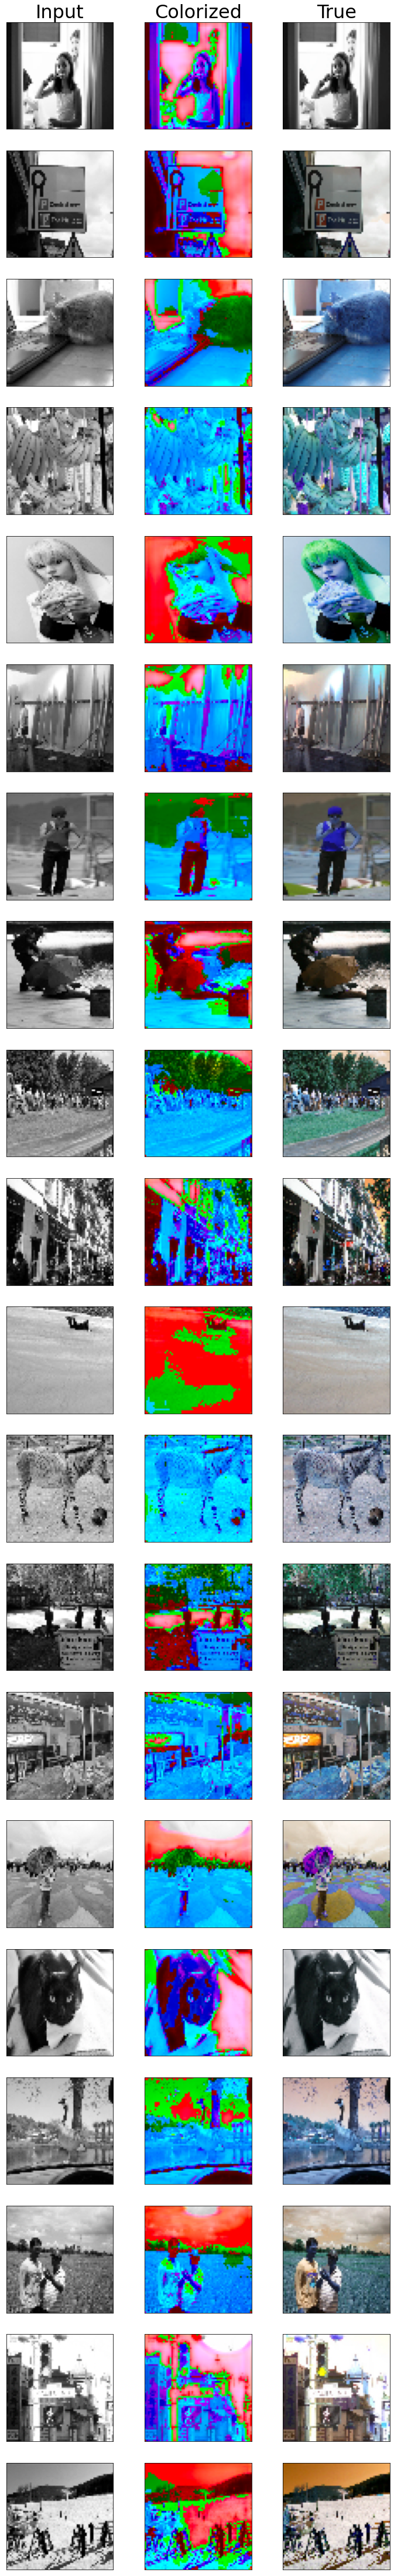

In [11]:
# Show test images
utils.display_images(
    generator=generator,
    X=X_test,
    y=y_test,
    count=20);